In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 11.1

In [5]:
df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


- `pulled_left:` Outcome ${0, 1}$ - indicator if the animal pulled the left-hand lever.


- `prosoc_left:` Predict ${0, 1}$ - Indicator if left-hand lever was(1) or not(0) the prosocial options.


- `condition:` Predict ${0, 1}$ - Indicator if there is a partner (1) or not (0) in the end table. 

### R Code 11.2

In [6]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


- treatment= $1$: prosoc_left = $0$ and contition= $0$: Two food items on **right** and **no partner**.


- treatment= $2$: prosoc_left = $1$ and contition= $0$: Two food items on **left** and **no partner**.


- treatment= $3$: prosoc_left = $0$ and contition= $1$: Two food items on **right** and **has partner**.


- treatment= $4$: prosoc_left = $1$ and contition= $1$: Two food items on **left** and **has partner**.

### R Code 11.3

In [7]:
df.pivot_table(['prosoc_left', 'condition'], 'treatment', aggfunc='count', margins=True)

,condition,prosoc_left
treatment,,
1,126,126
2,126,126
3,126,126
4,126,126
All,504,504


In [8]:
def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim \mbox{to be determined} $$
$$ \beta_k \sim \mbox{to be determined} $$

**Entendimento:**:

- **Likelihood**:

    Para esse caso os dados da resposta, *outcome*, são do tipo binários $0$ ou $1$. A função de likelihood apropriada para esses caso é a $Bernoulli(p)$, ou no caso $Binomial(1, p)$.

    Como $p$ é uma probabilidade, está entre $0$ e $1$, usamos uma *função de ligação* para **transformar** os resultados dos preditores para a escala de probabilidade. Nesse caso a função que faz essa transformação é:

$$ logit(p) = log(\frac{p}{1-p}) $$


- **Parameter $\alpha$**:

    Na função de ligação o parâmetro $\alpha$ é na verdade definido no modelo como um vetor (*vector*). O que estamos modelando aqui é que existe um parâmetro $\alpha$ para cada chimpanzé, ou seja, para cada *actor*.
    
    $$ \alpha[1] := \mbox{ Para o chimpanzé } 1 $$
    
    $$ \alpha[2] := \mbox{ Para o chimpanzé } 2 $$    
     
    $$ \alpha[3] := \mbox{ Para o chimpanzé } 3 $$    
    
    $$ \alpha[4] := \mbox{ Para o chimpanzé } 4 $$    
    
    $$ \alpha[5] := \mbox{ Para o chimpanzé } 5 $$    
    
    $$ \alpha[6] := \mbox{ Para o chimpanzé } 6 $$    
    
    $$ \alpha[7] := \mbox{ Para o chimpanzé } 7 $$
    
    Cada um dos parâmetros $\alpha$ tem um priori $Normal(\mu_i, \sigma_i)$ e essas prioris são idênticas.
    
    O que estamos inferindo com cada um desses $\alpha$'s é a localização ($\mu_i$) de cada uma das prioris e seu desvio padrão ($\sigma_i$)
    
    
    
- **Parameter $\beta$**:

    O $\beta$ é a representação de um vetor de $\beta$'s que mapeiam cada um dos tratamentos:
    
    $$ \beta[1] := \mbox{ Para o tratamento } 1 $$
    
    $$ \beta[2] := \mbox{ Para o tratamento } 2 $$
    
    $$ \beta[3] := \mbox{ Para o tratamento } 3 $$
    
    $$ \beta[4] := \mbox{ Para o tratamento } 4 $$
    

    No experimento existe uma hipóstese a ser testada: **Os chimpanzés tendem a puxar mais a alavanca do lado pro-social quando tem um outro chimpanzé do outro lado da mesa**, o *partner*?
    
    Os $\alpha$'s são independentes entre eles, porém quando colocamos os $\beta$'s estamos medindo qual é a inteção conjunta dos chimpanzés em cada tratamento.
    
    A variável tratamento (*treatment*) é a construção de uma **variável sintética que indexa** o conjunto de duas variáveis *{prosoc_left, condition}*, isto é, a **interação** entre elas. Então temos que a variável $treatment = 1$ indica que o experimento foi realizado usando dois pratos com comida no lado direito e que não tinha parceiro.
    
    Portando $\beta_{treatment = 1}$ terá o valor do *efeito de todos os experimentos* que os chimpanzés fizeram nesse tipo de tratamento.  

### R Code 11.4

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha $$

$$ \alpha \sim Normal(0, \omega) $$


$\omega = 10$ to start

In [9]:
# Creating data list to model
data_list_partial = df[['pulled_left', 'actor']].to_dict('list')
data_list_partial['N'] = len(df)
data_list_partial['qty_chimpanzees'] = len(df.actor.unique())

data_list_partial.keys()

dict_keys(['pulled_left', 'actor', 'N', 'qty_chimpanzees'])

In [10]:
model_partial = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 10);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial = stan.build(model_partial, data=data_list_partial)
samples_partial = posteriori_partial.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_13_9shfe/model_otww5cyi.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_13_9shfe/model_otww5cyi.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   4% (300/8000)
Sampling:  11% (900/8000)
Sampling:  19% (1500/8000)
Sampling:  44% (3500/8000)
Sampling:  65% (5200/8000)
Sampling:  82% (6600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.3e-

In [11]:
az.summary(samples_partial, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.343,0.247,-0.738,0.045,0.004,0.003,3325.0,2667.0,1.0
alpha[1],11.332,5.417,3.669,18.867,0.148,0.111,1651.0,1669.0,1.0
alpha[2],-0.638,0.250,-1.026,-0.244,0.004,0.003,3608.0,2876.0,1.0
alpha[3],-0.635,0.246,-1.009,-0.239,0.004,0.003,3741.0,2824.0,1.0
alpha[4],-0.343,0.246,-0.742,0.040,0.004,0.004,3110.0,2341.0,1.0
alpha[5],0.583,0.250,0.192,0.978,0.004,0.003,3276.0,2182.0,1.0
alpha[6],2.134,0.386,1.505,2.698,0.007,0.005,3582.0,2530.0,1.0


In [12]:
samples_partial = az.from_pystan(
    posterior_model=posteriori_partial,
    posterior=samples_partial,
    observed_data=['pulled_left', 'actor']
)

### R Code 11.5

In [13]:
# extract prior from quap
omega = 10
N = 1000

norm_prior = np.random.normal(0, omega, N)

### R Code 11.6

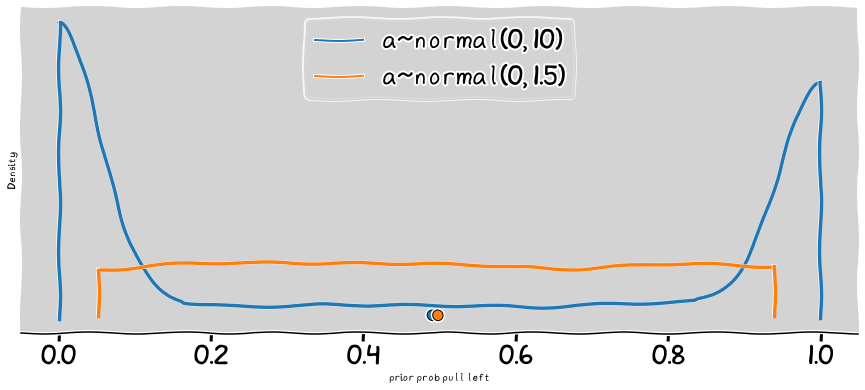

In [14]:
p = inv_logit(norm_prior)

omega = 1.5

better_p = inv_logit( np.random.normal(0, omega, N) ) 

az.plot_density([p, better_p],
                data_labels=['a~normal(0, 10)', 'a~normal(0, 1.5)'], 
                figsize=(15, 6))

plt.title('')
plt.xlabel('prior prob pull left')
plt.ylabel('Density')

plt.show()

In [15]:
model_partial_better = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial_better = stan.build(model_partial_better, data=data_list_partial)
samples_partial_better = posteriori_partial_better.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_b4q0sg8x/model_rj4e4nsu.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_b4q0sg8x/model_rj4e4nsu.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   9% (700/8000)
Sampling:  34% (2700/8000)
Sampling:  59% (4700/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7.6e-05 seconds
  1000 transitions using 10 leapfrog steps

In [16]:
az.summary(samples_partial_better, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.332,0.238,-0.689,0.063,0.003,0.003,6415.0,3278.0,1.00
alpha[1],3.912,0.714,2.745,4.961,0.010,0.008,6198.0,2602.0,1.00
alpha[2],-0.617,0.239,-0.988,-0.224,0.003,0.002,5723.0,3019.0,1.00
alpha[3],-0.621,0.249,-1.011,-0.208,0.003,0.003,5859.0,3034.0,1.01
alpha[4],-0.330,0.246,-0.722,0.063,0.003,0.003,5647.0,2964.0,1.00
alpha[5],0.560,0.243,0.182,0.942,0.003,0.002,6209.0,3204.0,1.00
alpha[6],2.011,0.367,1.453,2.613,0.005,0.004,6096.0,2923.0,1.00


In [17]:
samples_parcial_better = az.from_pystan(
    posterior=samples_partial_better,
)

### R Code 11.7

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 10) $$

In [18]:
# quap code to get priori

### R Code 11.8

In [19]:
p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 10, (4, N))

p = [inv_logit(alpha + beta) for beta in betas]

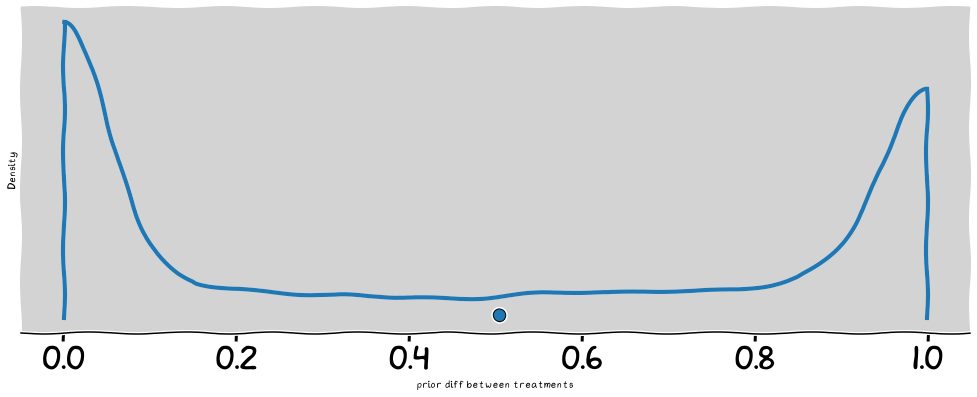

In [20]:
az.plot_density(np.absolute(p[0] - p[1]), figsize=(17, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.9

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 0.5) $$

In [21]:
better_p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 0.5, (4, N))

better_p = [inv_logit(alpha + beta) for beta in betas]

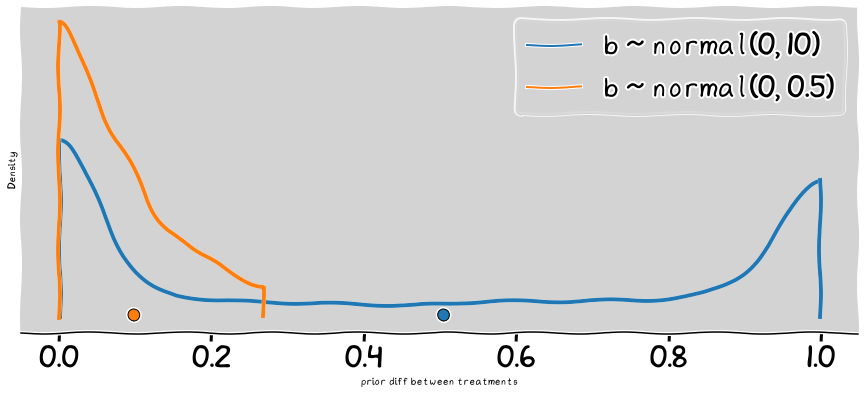

In [22]:
az.plot_density([
        np.absolute(p[0] - p[1]), 
        np.absolute(better_p[0] - better_p[1])
    ], 
    data_labels=['b ~ normal(0, 10)', 'b ~ normal(0, 0.5)'],
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

In [23]:
np.mean(np.absolute(better_p[0] - better_p[1]))

0.09772701525017025

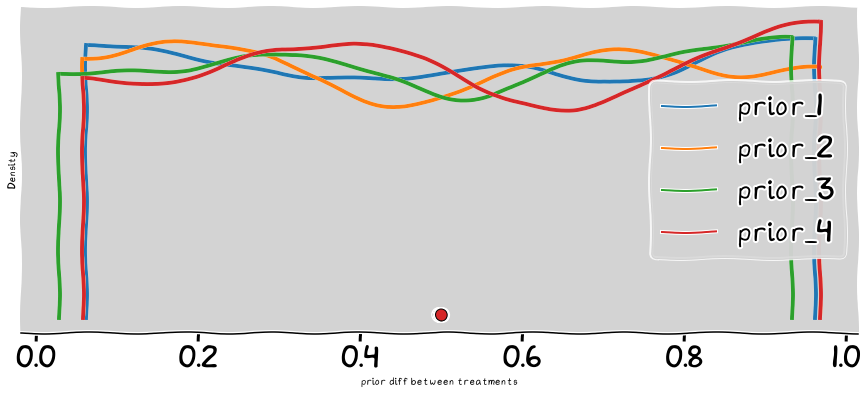

In [24]:
# Plot the 4 prior

az.plot_density([
        better_p[0], 
        better_p[1], 
        better_p[2], 
        better_p[3], 
    ],
    data_labels=['prior_1', 'prior_2', 'prior_3', 'prior_4'], 
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.10

In [25]:
data_list = df[['pulled_left', 'actor', 'treatment']].to_dict('list')
data_list['N'] = len(df)
data_list['qty_chimpanzees'] = len(df.actor.unique())
data_list['qty_treatment'] = len(df.treatment.unique())

data_list.keys()

dict_keys(['pulled_left', 'actor', 'treatment', 'N', 'qty_chimpanzees', 'qty_treatment'])

### R Code 11.11

In [26]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_treatment;
        int pulled_left[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
        vector[qty_treatment] beta;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [27]:
samples_chimpanzees = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['pulled_left', 'actor', 'treatment']
)

In [28]:
az.summary(samples_chimpanzees, var_names=['alpha', 'beta'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.455,0.325,-0.972,0.073,0.009,0.006,1260.0,2259.0,1.0
alpha[1],3.889,0.752,2.665,5.027,0.014,0.010,3157.0,2629.0,1.0
alpha[2],-0.755,0.337,-1.257,-0.173,0.009,0.007,1330.0,2109.0,1.0
alpha[3],-0.751,0.331,-1.273,-0.226,0.009,0.007,1272.0,2470.0,1.0
alpha[4],-0.458,0.327,-0.996,0.035,0.009,0.007,1199.0,2301.0,1.0
alpha[5],0.472,0.336,-0.073,0.991,0.009,0.006,1345.0,1898.0,1.0
alpha[6],1.955,0.419,1.271,2.596,0.010,0.007,1640.0,2025.0,1.0
beta[0],-0.032,0.280,-0.487,0.411,0.008,0.006,1122.0,1855.0,1.0
beta[1],0.486,0.280,0.058,0.953,0.008,0.006,1121.0,2205.0,1.0
beta[2],-0.380,0.291,-0.847,0.075,0.009,0.006,1158.0,2110.0,1.0


### R Code 11.12

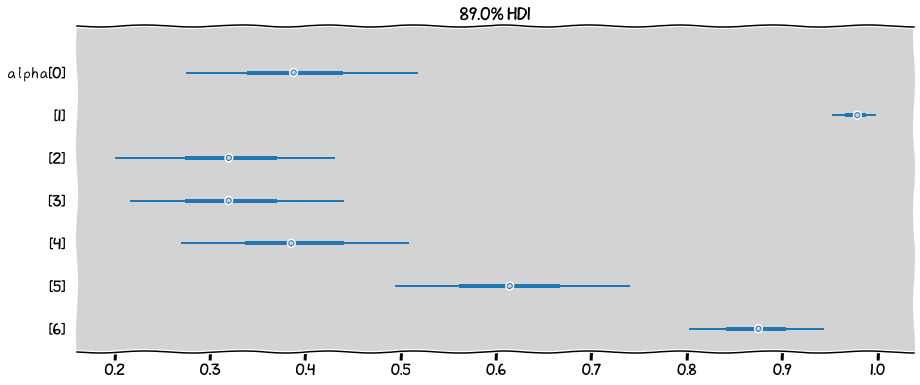

In [29]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

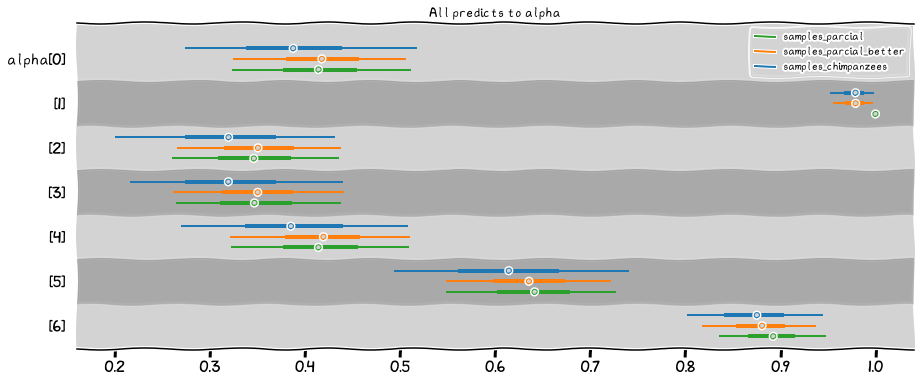

In [30]:
ax = az.plot_forest([samples_chimpanzees, samples_parcial_better, samples_partial], 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities,
                    model_names=['samples_chimpanzees', 'samples_parcial_better', 'samples_parcial'],
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

plt.title('All predicts to alpha')

plt.show()

### R Code 11.13

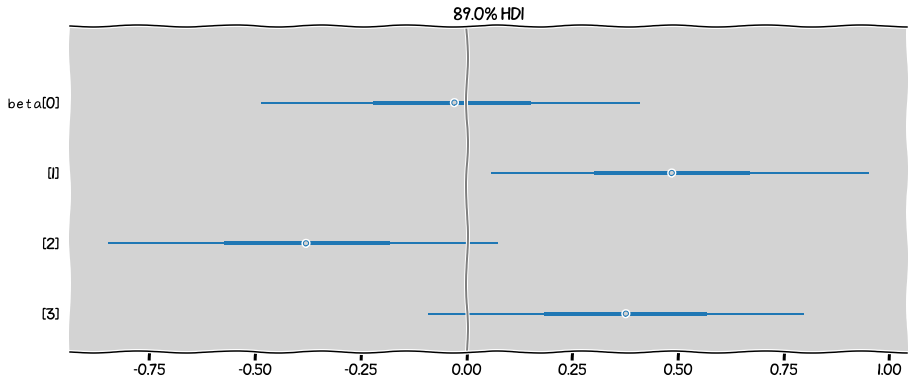

In [31]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))
plt.axvline(x=0, c='gray')
plt.show()

### R Code 8.14

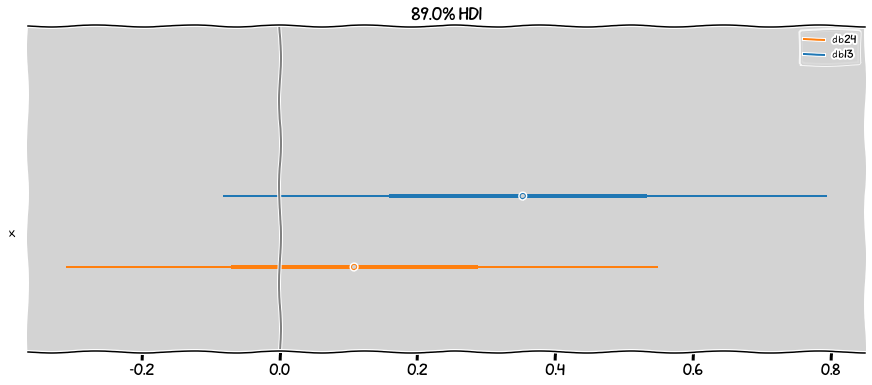

In [32]:
beta_0 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)
beta_1 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)
beta_2 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)
beta_3 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)

diff_beta_0_2 = az.extract(beta_0 - beta_2)
diff_beta_1_3 = az.extract(beta_1 - beta_3)

az.plot_forest(
    [diff_beta_0_2.beta.values, diff_beta_1_3.beta.values],
    combined=True,  # Joint all chains 
    kind="forestplot", # or ridgeplot to plot densities
    # transform=inv_logit,
    model_names=['db13', 'db24'],
    hdi_prob=0.89,
    figsize=(15, 6)
)

plt.axvline(x=0, c='gray')

plt.show()

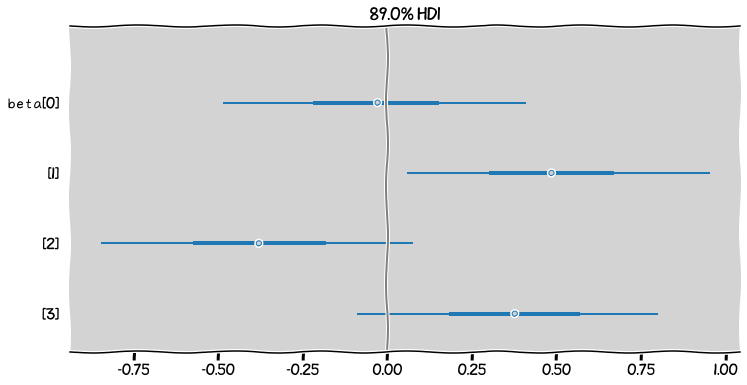

In [33]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(12, 6))

plt.axvline(x=0, c='gray')
plt.show()

### R Code 11.15

In [34]:
pl = df.groupby(['actor', 'treatment'])[['actor', 'treatment', 'pulled_left']].mean(['pulled_left'])

pl.loc[pl.actor == 1]

actor  treatment  pulled_left
actor treatment                               
1     1            1.0        1.0     0.333333
      2            1.0        2.0     0.500000
      3            1.0        3.0     0.277778
      4            1.0        4.0     0.555556

### R Code 11.16 and R Code 11.17

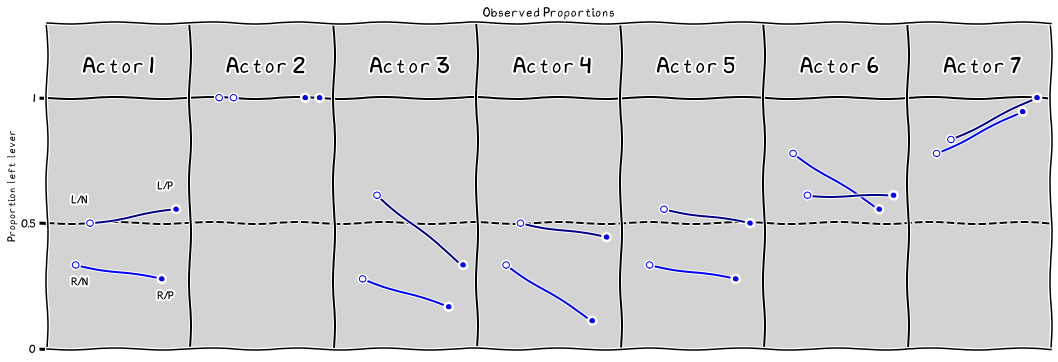

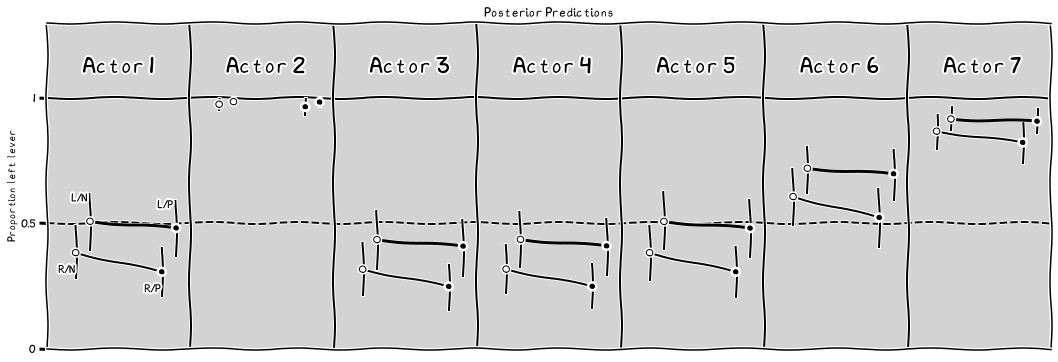

In [35]:
# R Code 11.16

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    RN, LN, RP, LP = pl.loc[pl.actor == i + 1, 'pulled_left'].values

    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN, RP], color='blue')
    plt.plot(0.2 + i, RN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.8 + i, RP, 'o', markerfacecolor='blue', color='white')
    
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN, LP], color='darkblue')
    plt.plot(0.3 + i, LN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.9 + i, LP, 'o', markerfacecolor='blue', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.17, y=RN - 0.08, s='R/N')
        plt.text(x=0.77, y=RP - 0.08, s='R/P')
        plt.text(x=0.17, y=LN + 0.08, s='L/N')
        plt.text(x=0.77, y=LP + 0.08, s='L/P')
    
plt.title('Observed Proportions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()


# R Code 11.17
# ============

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    alpha_chimp = az.extract(samples_chimpanzees.posterior.alpha.sel(alpha_dim_0=i)).alpha.values
    
    RN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)).beta.values)
    LN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values)
    RP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)).beta.values)
    LP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values)
    
    # To R/N and R/P
    # ===============
    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN.mean(), RP.mean()], color='black')
    
    # Plot hdi compatibility interval
    RN_hdi_min, RN_hdi_max = az.hdi(RN, hdi_prob=0.89)
    RP_hdi_min, RP_hdi_max = az.hdi(RP, hdi_prob=0.89)
    plt.plot([0.2 + i, 0.2 + i], [RN_hdi_min, RN_hdi_max], c='black')
    plt.plot([0.8 + i, 0.8 + i], [RP_hdi_min, RP_hdi_max], c='black')
    
    # Plot points
    plt.plot(0.2 + i, RN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.8 + i, RP.mean(), 'o', markerfacecolor='black', color='white')
    
    # To L/N and L/P
    # ===============
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN.mean(), LP.mean()], color='black', linewidth=3)

    # Plot hdi compatibility interval
    LN_hdi_min, LN_hdi_max = az.hdi(LN, hdi_prob=0.89)
    LP_hdi_min, LP_hdi_max = az.hdi(LP, hdi_prob=0.89)
    plt.plot([0.3 + i, 0.3 + i], [LN_hdi_min, LN_hdi_max], c='black')
    plt.plot([0.9 + i, 0.9 + i], [LP_hdi_min, LP_hdi_max], c='black')

    plt.plot(0.3 + i, LN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.9 + i, LP.mean(), 'o', markerfacecolor='black', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.08, y=RN.mean() - 0.08, s='R/N')
        plt.text(x=0.68, y=RP.mean() - 0.08, s='R/P')
        plt.text(x=0.17, y=LN.mean() + 0.08, s='L/N')
        plt.text(x=0.77, y=LP.mean() + 0.08, s='L/P')
    
plt.title('Posterior Predictions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()

### R Code 11.18

In [36]:
df['side'] = df.prosoc_left + 1  # Right 1, Left 2  - Because R start index in 1
df['cond'] = df.condition + 1  # no partner 1, partner 2 - Because R start index in 1

### R Code 11.19

In [37]:
# Creating data list 2 to model
data_list2 = df[['pulled_left', 'actor', 'side', 'cond']].to_dict('list')
data_list2['N'] = len(df)
data_list2['qty_actors'] = len(df.actor.unique())
data_list2['qty_side'] = len(df.side.unique())
data_list2['qty_cond'] = len(df.cond.unique())

data_list2.keys()

dict_keys(['pulled_left', 'actor', 'side', 'cond', 'N', 'qty_actors', 'qty_side', 'qty_cond'])

In [38]:
model2 = """
    data {
        int N;
        int qty_actors;
        int qty_side;
        int qty_cond;
        
        int pulled_left[N];
        int actor[N];
        int side[N];
        int cond[N];
    }
    
    parameters {
        vector[qty_actors] alpha;
        vector[qty_side] bs;
        vector[qty_cond] bc;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        bs ~ normal(0, 0.5);
        bc ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + bs[ side[i] ] + bc[ cond[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori2 = stan.build(model2, data=data_list2)
samples2 = posteriori2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 9, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-forma

In [39]:
samples_chimpanzees_2 = az.from_pystan(
    posterior_model=posteriori2,
    posterior=samples2,
    observed_data=['pulled_left', 'actor', 'side', 'cond']
)

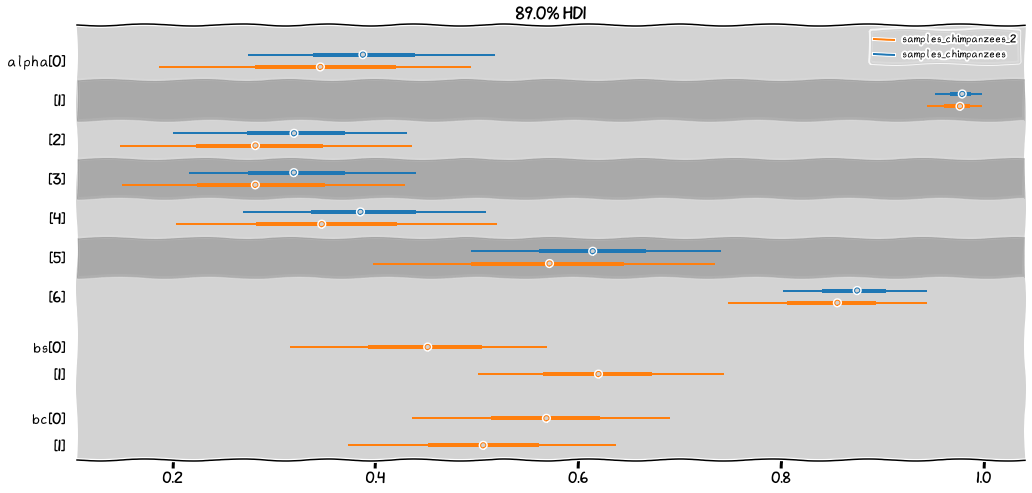

In [40]:
ax = az.plot_forest([samples_chimpanzees, samples_chimpanzees_2],
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha', 'bs', 'bc'], 
                    model_names=['samples_chimpanzees', 'samples_chimpanzees_2'],
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(17, 8))
plt.show()

### R Code 11.21

To viewing data from rethinking packages

### R Code 11.22

Comparing two models

### R Code 11.23

In [41]:
beta_4 = az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values
beta_2 = az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values

np.mean( np.exp(beta_4 - beta_2) )

0.9290632981448784

### R Code 11.24

In [42]:
d = pd.read_csv('./data/chimpanzees.csv', sep=';')
d['treatment'] = 1 + d['prosoc_left'] + 2 * d['condition']
d['side'] = d['prosoc_left'] + 1  # right 1, left 2
d['cond'] = d['condition'] + 1  # no partner 1, partner 2

d_aggregate = d.groupby(['treatment', 'actor', 'side', 'cond'])[['pulled_left']].sum('pulled_left').copy()
d_aggregate.rename(columns={'pulled_left': 'left_pulls'}, inplace=True)  # Rename columns
d_aggregate.reset_index(inplace=True)
d_aggregate.head(8)

,treatment,actor,side,cond,left_pulls
0,1,1,1,1,6
1,1,2,1,1,18
2,1,3,1,1,5
3,1,4,1,1,6
4,1,5,1,1,6
5,1,6,1,1,14
6,1,7,1,1,14
7,2,1,2,1,9


### R Code 11.25

In [43]:
dat = d_aggregate[['left_pulls', 'treatment', 'actor', 'side', 'cond']].to_dict('list')
dat['N'] = len(d_aggregate)
dat['qty_actors'] = len(d_aggregate.actor.unique())
dat['qty_treatments'] = len(d_aggregate.treatment.unique())

dat.keys()

dict_keys(['left_pulls', 'treatment', 'actor', 'side', 'cond', 'N', 'qty_actors', 'qty_treatments'])

In [44]:
model = """
    data {
        int N;
        int qty_actors;
        int qty_treatments;
        
        int left_pulls[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_actors] alpha;
        vector[qty_treatments] beta;
    }
    
    model {
        vector[N] p;
        
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
    
        left_pulls ~ binomial(18, p);
    }
"""

posteriori = stan.build(model, data=dat)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_tg7y7gna/model_3sv2or3b.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_tg7y7gna/model_3sv2or3b.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_tg7y7gna/model_3sv2or3b.stan', line 9, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [45]:
model_chimp_bin = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['left_pulls', 'treatment', 'actor'],
)

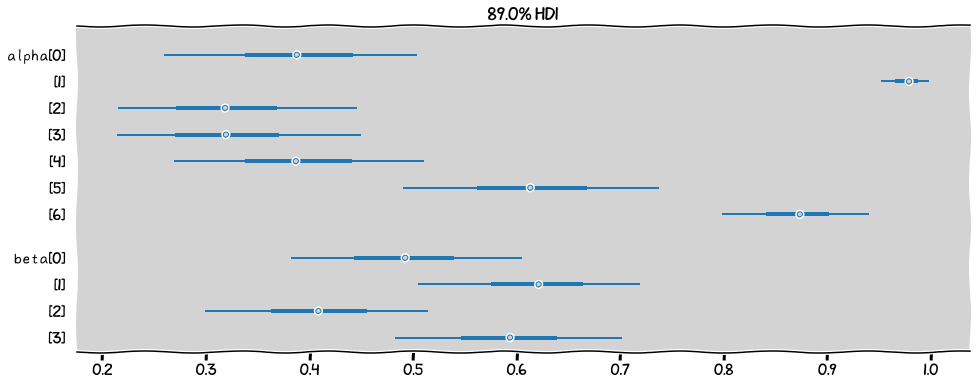

In [46]:
az.plot_forest(
    model_chimp_bin, 
    var_names=['alpha', 'beta'], 
    combined=True, 
    transform=inv_logit, 
    figsize=(16, 6),
    hdi_prob=0.89,
)

plt.show()

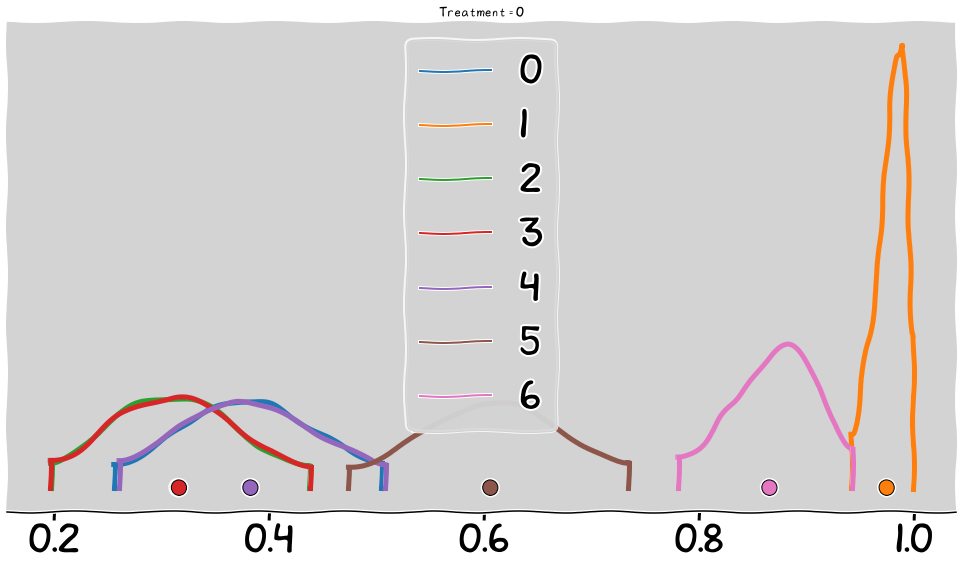

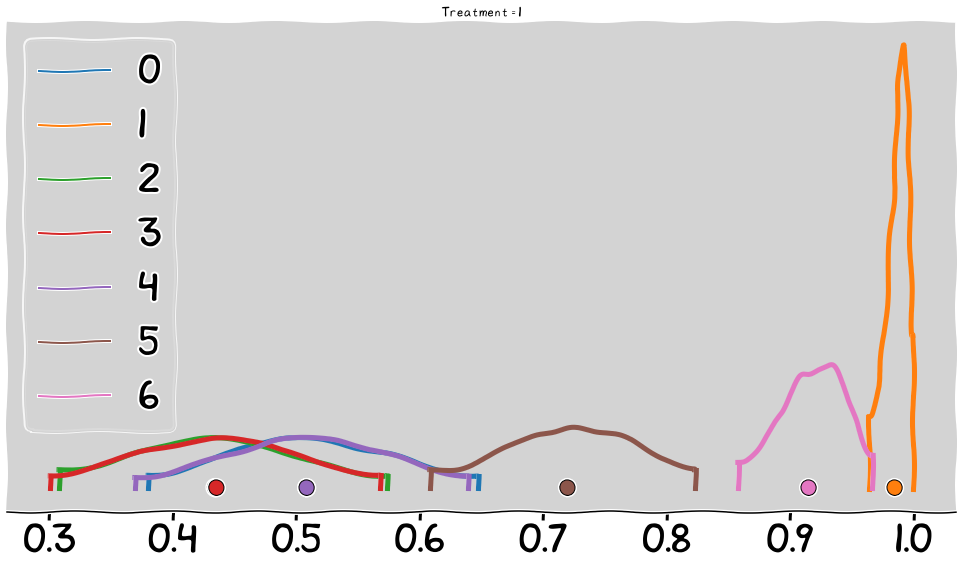

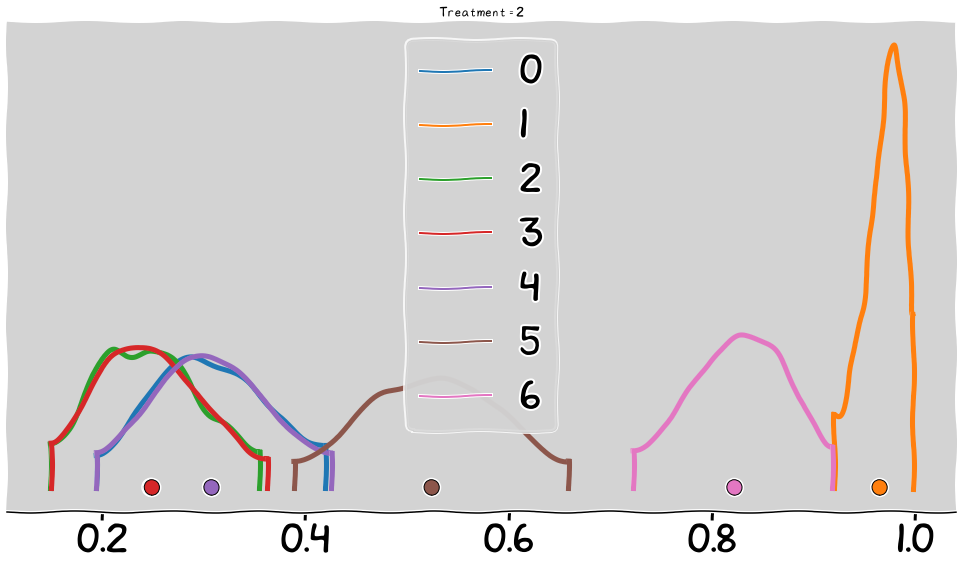

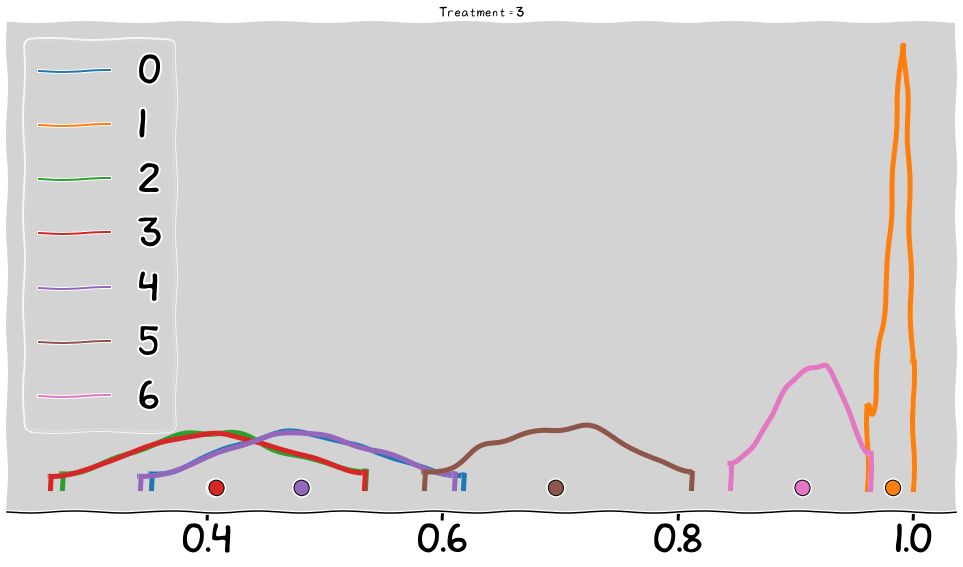

In [47]:

for t in range(4):
    p_chimp_bin = []
    for i in range(7):
        alpha_chimp_bin = model_chimp_bin.posterior.alpha.sel(alpha_dim_0=i).values.flatten()
        beta_chimp_bin = model_chimp_bin.posterior.beta.sel(beta_dim_0=t).values.flatten()

        p_chimp_bin.append(inv_logit(alpha_chimp_bin + beta_chimp_bin))

    az.plot_density(p_chimp_bin, figsize=(17, 9))
    plt.title(f'Treatment = {t}')

plt.show()

### R Code 11.26

In [48]:
models_to_compare = {'model_chimp_bin': model_chimp_bin, 'samples_chimpanzees': samples_chimpanzees}

# az.compare(models_to_compare)  # or use 'elpd_waic' to WAIC

# XXX: Need to make posteriori in model to read in arviz

### R Code 11.27

In [49]:
# Deviance of aggregated 6-in-9
agg = -2 * np.log(stats.binom.pmf(k=6, n=9, p=0.2))
print(agg)

# Deviance of dis-aggregagted
k = [1, 1, 1, 1, 1, 1, 0, 0, 0]

not_agg = -2 * np.sum(np.log(stats.bernoulli.pmf(k=k, p=0.2)))
print(not_agg)

11.790482659407832
20.652116257094463


### My Tests

In [50]:
N = 100
p = np.random.rand()

y = np.random.binomial(1, p, N)

In [51]:
model = """
    data{
        int N;
        int y[N];
    }
    
    parameters {
        real alpha;
    }
    
    model {
        vector[N] p;
        
        // Priori
        alpha ~ normal(0.5, 1);
    
        for (i in 1:N){
                p[i] = inv_logit(alpha);
        }
    
        // Likelihood
        y ~ binomial(1, p);
    }
"""

data = {
    'N':N,
    'y': y,
}

posteriori = stan.build(model, data=data)
samples_test = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_74_5_884/model_xxtbv5ph.stan', line 4, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

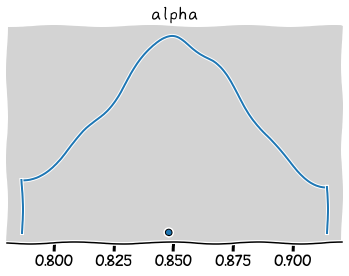

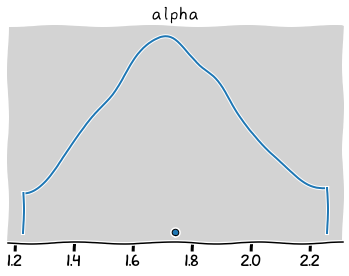

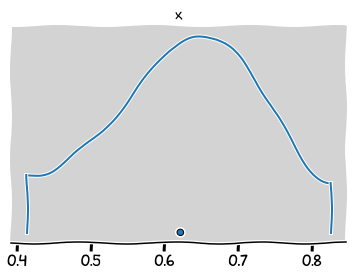

In [52]:
samples_test_az = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples_test,
    observed_data=['y']
)

az.plot_density(
    samples_test_az, var_names=['alpha'], 
    transform=inv_logit)

az.plot_density(
    samples_test_az, var_names=['alpha'])

az.plot_density(inv_logit(np.random.normal(0.5, 0.5, 1000)))  # Priori

plt.show()

In [53]:
print(p, np.mean(inv_logit(samples_test_az.posterior.alpha.values)))

0.7883723021136118 0.848092887471232


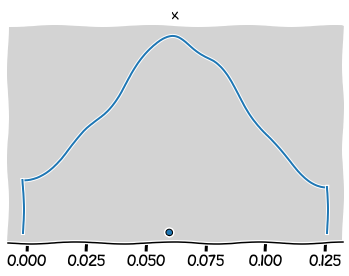

In [54]:
az.plot_density(inv_logit(samples_test_az.posterior.alpha.values) - p)
plt.show()

In [55]:
# Binomial

N = 100
p = np.random.rand()

y = np.random.binomial(5, p, N)

In [56]:
model = """
    data{
        int N;
        int y[N];
    }
    
    parameters {
        real alpha;
    }
    
    model {
        vector[N] p;
        
        // Priori
        alpha ~ normal(0.5, 1);
    
        for (i in 1:N){
                p[i] = inv_logit(alpha);
        }
    
        // Likelihood
        y ~ binomial(5, p);
    }
"""

data = {
    'N':N,
    'y': y,
}

posteriori = stan.build(model, data=data)
samples_test = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_yywp3af8/model_vjz4b4we.stan', line 4, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

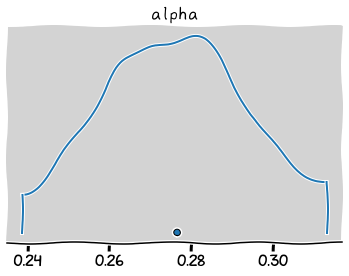

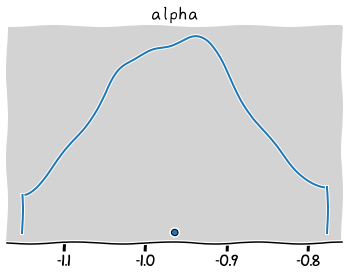

In [57]:
samples_test_az = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples_test,
    observed_data=['y']
)

az.plot_density(
    samples_test_az, var_names=['alpha'], 
    transform=inv_logit)

az.plot_density(
    samples_test_az, var_names=['alpha'])

plt.show()

In [58]:
print(p, np.mean(inv_logit(samples_test_az.posterior.alpha.values)))

0.2807667319959184 0.2765335007283015


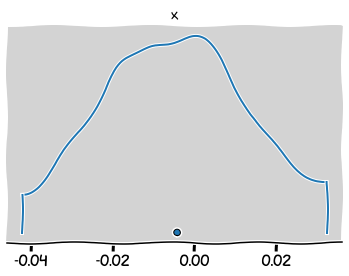

In [59]:
az.plot_density(inv_logit(samples_test_az.posterior.alpha.values) - p)
plt.show()